In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [3]:
PROJECT_PATH = '/content/drive/My Drive/Datasets/ML Project'
FIGURES_PATH = f'{PROJECT_PATH}/figures/preprocessing'
def get_figure_path(name: str):
  return f'{FIGURES_PATH}/{name}.png'
DATASETS_PATH = f'{PROJECT_PATH}/data/recommended'
TRAINING_PATH = f'{DATASETS_PATH}/training/training.csv'
TESTING_PATH = f'{DATASETS_PATH}/test/test.csv'
INDEX_COL = 'pkSeqID'
COLUMNS_ORDERED = [
    'min', 'max', 'mean', 'stddev',
    'saddr', 'sport', 'daddr', 'dport',
    'srate', 'drate',
    'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP',
    'state_number', 'proto',
    'seq',
    'attack', 'category', 'subcategory'
]

In [4]:
training = pd.read_csv(TRAINING_PATH, index_col=INDEX_COL)[COLUMNS_ORDERED]
training.head()

,min,max,mean,stddev,saddr,sport,daddr,dport,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,state_number,proto,seq,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,192.168.100.150,6551,192.168.100.3,80,0.494549,0.0,100,100,4,udp,251984,1,DDoS,UDP
2432264,3.856930,4.012924,3.934927,0.078003,192.168.100.150,5532,192.168.100.3,80,0.256493,0.0,38,100,3,tcp,256724,1,DDoS,TCP
1976315,2.974100,3.609205,3.341429,0.268666,192.168.100.147,27165,192.168.100.3,80,0.294880,0.0,100,100,3,tcp,62921,1,DDoS,TCP
1240757,0.000000,4.942302,3.222832,1.823185,192.168.100.150,48719,192.168.100.3,80,0.461435,0.0,63,63,4,udp,99168,1,DoS,UDP
3257991,2.979995,4.994452,3.983222,0.822418,192.168.100.147,22461,192.168.100.3,80,1.002999,0.0,100,100,4,udp,105063,1,DDoS,UDP


In [5]:
testing = pd.read_csv(TESTING_PATH, index_col=INDEX_COL)[COLUMNS_ORDERED]

In [6]:
def process_categories(cat):
  if str(cat).lower().startswith('theft'):
    return 'Theft'
  if str(cat).lower().startswith('normal'):
    return 'Normal'
  if cat == 'DoS HTTP':
    return 'DoS TCP'
  if cat == 'DDoS HTTP':
    return 'DDoS TCP'
  return cat


In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cat_encoder_hot = OneHotEncoder()
cat_encoder_label = LabelEncoder()

In [8]:
X_train = training.drop(['attack' ,'category', 'subcategory'], axis=1)
y_train_cat = pd.DataFrame({'category': (training['category'] + ' ' + training['subcategory']).map(process_categories)})
y_train_hot = cat_encoder_hot.fit_transform(y_train_cat)
y_train_label = cat_encoder_label.fit_transform(y_train_cat['category'])

In [9]:
X_test = testing.drop(['attack', 'category', 'subcategory'], axis=1)
y_test_cat = pd.DataFrame({'category': (testing['category'] + ' ' + testing['subcategory']).map(process_categories)})
y_test_hot = cat_encoder_hot.transform(y_test_cat)
y_test_label = cat_encoder_label.transform(y_test_cat['category'])

In [10]:
del training
del testing
gc.collect()

0

In [11]:
X_train.head()

,min,max,mean,stddev,saddr,sport,daddr,dport,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,state_number,proto,seq
pkSeqID,,,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,192.168.100.150,6551,192.168.100.3,80,0.494549,0.0,100,100,4,udp,251984
2432264,3.856930,4.012924,3.934927,0.078003,192.168.100.150,5532,192.168.100.3,80,0.256493,0.0,38,100,3,tcp,256724
1976315,2.974100,3.609205,3.341429,0.268666,192.168.100.147,27165,192.168.100.3,80,0.294880,0.0,100,100,3,tcp,62921
1240757,0.000000,4.942302,3.222832,1.823185,192.168.100.150,48719,192.168.100.3,80,0.461435,0.0,63,63,4,udp,99168
3257991,2.979995,4.994452,3.983222,0.822418,192.168.100.147,22461,192.168.100.3,80,1.002999,0.0,100,100,4,udp,105063


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split

In [13]:
def process_port(p):
  return int(p, 16) if str(p).startswith('0x') else int(p)

def process_ports(ports: pd.DataFrame):
  return ports.map(process_port)


In [14]:
DEFAULT_RATE_SHIFT = 1.1

In [15]:
def shift_and_log(data, shift=DEFAULT_RATE_SHIFT): # 1.1 So that the output has no zero values, and a small change is not that significant
  return np.log10(data + shift)

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

srate_idx, drate_idx = [list(X_train.columns).index('srate'), list(X_train.columns).index('drate')]
class CombinedFeatureAdder(BaseEstimator, TransformerMixin):
  def __init__(self, normalize=True) -> None:
    super().__init__()
    self.normalize = normalize

  def fit(self, X, y=None):
    return self

  def transform(self, X: pd.DataFrame, y=None):
    srate_to_drate = np.log10(X.loc[:, 'srate'] + DEFAULT_RATE_SHIFT) / np.log10(X.loc[:, 'drate'] + DEFAULT_RATE_SHIFT)
    if self.normalize:
      return X.assign(srate_to_drate=np.log1p(srate_to_drate))
    else:
      return X.assign(srate_to_drate=srate_to_drate)

In [17]:
TO_DROP = ['saddr', 'daddr', 'seq']

data_cleaner = ColumnTransformer([
  ('drop', 'drop', TO_DROP),
  ('encode', OneHotEncoder(), ['proto']),
  ('port', FunctionTransformer(func=process_ports), ['sport', 'dport']),
  ('rate', FunctionTransformer(func=shift_and_log), ['srate', 'drate']),
], remainder='passthrough')

data_prep = Pipeline([
    ('augment', CombinedFeatureAdder()),
    ('clean', data_cleaner),
    ('std', StandardScaler()),
])

In [18]:
X_train_cleaned = data_prep.fit_transform(X_train)

In [19]:
X_train_cleaned.shape

(2934817, 17)

In [20]:
%%script true
X_train_eval, _, y_train_eval_label, _, y_train_eval_hot, _, indices, _ = train_test_split(
    X_train_cleaned,
    y_train_label,
    y_train_hot,
    [i for i in range(len(y_train_label))],
    train_size=0.1,
    stratify=y_train_label,
    random_state=42
)

# Polynomial Features

In [21]:
from sklearn.preprocessing import PolynomialFeatures

data_prep_poly = Pipeline([
    ('augment', CombinedFeatureAdder()),
    ('clean', data_cleaner),
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True))
])

In [22]:
X_train_poly = data_prep_poly.fit_transform(X_train)

Polynomial features generate a lot of data, and quickly eat up the memory of the machine during training

Feature reduction techniques might be useful here so `PCA` is evaluated directly

In [23]:
from sklearn.decomposition import PCA

In [24]:
data_prep_poly = Pipeline([
    ('augment', CombinedFeatureAdder()),
    ('clean', data_cleaner),
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('pca', PCA(n_components=0.8)),
])

In [25]:
pca = PCA(n_components=0.8)
X_train_poly_pca = pca.fit_transform(X_train_poly)

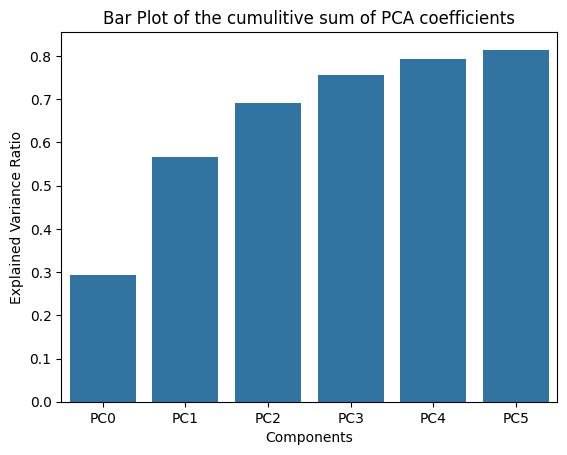

In [26]:
sns.barplot(x=[f'PC{i}' for i in range(len(pca.explained_variance_ratio_))], y=np.cumsum(pca.explained_variance_ratio_))
title = 'Bar Plot of the cumulitive sum of PCA coefficients'
plt.title(title)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.savefig(get_figure_path(title))

In [27]:
del X_train_poly
del X_train_poly_pca
gc.collect()

3707

In [28]:
%%script true
pca = PCA(n_components=2)
X_train_poly_pca_2 = pca.fit_transform(X_train_poly)

In [29]:
%%script true
sns.scatterplot(x=X_train_poly_pca_2[:, 0], y=X_train_poly_pca_2[:, 1], hue=y_train_label)
title = 'Scatter plot of data per category with 2 principle components (polynomial features)'
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title(title)
plt.savefig(get_figure_path(title))

In [30]:
X_train_poly = data_prep_poly.fit_transform(X_train)

In [31]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
}

no_poly_results = []
poly_results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    y_target = y_train_label

    X_no_poly = X_train_cleaned
    X_poly = X_train_poly  # assuming you have this variable

    print(f'Processing model {model_name}...')

    print('No Polynomial Features')
    start_time = time.time()
    cv_scores_no_poly = cross_val_score(model, X_no_poly, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    no_poly_time = time.time() - start_time

    print('With Polynomial Features')
    start_time = time.time()
    cv_scores_poly = cross_val_score(model, X_poly, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    poly_time = time.time() - start_time

    no_poly_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_no_poly),
        'cv_std': np.std(cv_scores_no_poly),
        'scores': cv_scores_no_poly,
        'time': no_poly_time
    })

    poly_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_poly),
        'cv_std': np.std(cv_scores_poly),
        'scores': cv_scores_poly,
        'time': poly_time
    })

    print(f'  No Poly: {no_poly_time:.2f}s, With Poly: {poly_time:.2f}s')
    print(f'Done.\n')

no_poly_df = pd.DataFrame(no_poly_results)
poly_df = pd.DataFrame(poly_results)


Processing model Logistic Regression...
No Polynomial Features
With Polynomial Features
  No Poly: 725.75s, With Poly: 625.47s
Done.

Processing model Random Forest...
No Polynomial Features


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


With Polynomial Features


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  No Poly: 116.29s, With Poly: 100.37s
Done.

Processing model KNN...
No Polynomial Features


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


With Polynomial Features
  No Poly: 364.14s, With Poly: 208.78s
Done.



In [32]:
summary_df = pd.DataFrame({
    'model': no_poly_df['model'],
    'no_poly_acc': no_poly_df['cv_mean'],
    'no_poly_std': no_poly_df['cv_std'],
    'no_poly_time': no_poly_df['time'],
    'poly_acc': poly_df['cv_mean'],
    'poly_std': poly_df['cv_std'],
    'poly_time': poly_df['time'],
    'difference': poly_df['cv_mean'] - no_poly_df['cv_mean'],
    'speedup': (no_poly_df['time'] / poly_df['time']).round(2),
})

summary_df

,model,no_poly_acc,no_poly_std,no_poly_time,poly_acc,poly_std,poly_time,difference,speedup
0,Logistic Regression,0.932038,0.000214,725.747717,0.582759,0.008031,625.467362,-0.349278,1.16
1,Random Forest,0.993427,0.000135,116.288763,0.985457,0.000470,100.371938,-0.007969,1.16
2,KNN,0.997939,0.000041,364.142028,0.996142,0.000078,208.781197,-0.001797,1.74


Well using Polynomial Features with PCA didn't help much, neither the performance nor the accuracy
And adding Polynomial Features would greatly increase the training time and probably not add that much value, so best to keep it as is

| model              | no_poly_acc | no_poly_std | no_poly_time | poly_acc | poly_std | poly_time | difference | speedup |
|--------------------|-------------|-------------|--------------|----------|----------|-----------|------------|---------|
| Logistic Regression| 0.932038    | 0.000214    | 725.747717   | 0.582759 | 0.008031 | 625.467362 | -0.349278 | 1.16    |
| Random Forest      | 0.993427    | 0.000135    | 116.288763  | 0.985457 | 0.000470 | 100.371938 | -0.007969 | 1.16    |
| KNN                | 0.997939    | 0.000041    | 364.142028  | 0.996142 | 0.000078 | 208.781197 | -0.001797 | 1.74    |

In [33]:
%%script false

CalledProcessError: Command 'b' \n'' returned non-zero exit status 1.

# DBSCAN

In [ ]:
from cuml.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

def score_dbscan(eps, min_samples, X):
    print(f'Processing eps={eps}, min_samples={min_samples}...')
    model = DBSCAN(eps=eps, min_samples=min_samples)
    predictions = model.fit_predict(X)
    print('Model fitted.')
    out = {
        'eps': eps,
        'min_samples': min_samples,
        'davies': davies_bouldin_score(X_train_eval, predictions),
        'predictions': predictions,
        'classes': len(np.unique(predictions)),
        'outliers': sum(predictions == -1),
    }
    print('Done processing.')
    return out

In [ ]:
%%script true
eps = [0.5, 1]
min_samples = [5, 50]

scores = []

for v1 in eps:
  for v2 in min_samples:
    scores.append(score_dbscan(v1, v2, X_train_eval))

pd.DataFrame(scores).drop('predictions', axis=1)

In [ ]:
%%script true
test_1_scores = scores
pd.DataFrame(test_1_scores).drop('predictions', axis=1)

In [ ]:
%%script true
eps = [1, 5, 10, 20, 30, 50, 100]
min_samples = 50
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))


In [ ]:
%%script true
test_2_scores = scores
pd.DataFrame(test_2_scores).drop('predictions', axis=1)

In [ ]:
%%script true
eps = [i for i in range(21, 30)]
min_samples = 50
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))

In [ ]:
%%script true
test_3_scores = scores
pd.DataFrame(test_3_scores).drop('predictions', axis=1)

It seems the optimum epsilon value is 27

In [ ]:
%%script true
eps = 27
min_samples = [5, 10, 20, 50, 100, 200, 300]
scores = []

for m in min_samples:
  scores.append(score_dbscan(eps, m, X_train_eval))

In [ ]:
%%script true
test_4_scores = scores
pd.DataFrame(test_4_scores).drop('predictions', axis=1)

This clearly shows that lower values of min_samples improve the model significantly, need to try > 5

In [ ]:
%%script true
eps = 27
min_samples = [i for i in range(1, 5)]
scores = []

for m in min_samples:
  scores.append(score_dbscan(eps, m, X_train_eval))

In [ ]:
%%script true
test_5_scores = scores
pd.DataFrame(test_5_scores).drop('predictions', axis=1)

In [ ]:
%%script true
eps = [(27 + 0.1 * i) for i in range(1, 10)]
min_samples = 10
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))

In [ ]:
%%script true
test_6_scores = scores
pd.DataFrame(test_6_scores).drop('predictions', axis=1)

In [ ]:
from sklearn.metrics import silhouette_score

def silhouette_score_dbscan(eps, min_samples, X):
    print(f'Processing eps={eps}, min_samples={min_samples}...')
    model = DBSCAN(eps=eps, min_samples=min_samples)
    predictions = model.fit_predict(X)
    print('Model fitted.')
    out = {
        'eps': eps,
        'min_samples': min_samples,
        'silouhette': silhouette_score(X_train_eval, predictions, n_jobs=-1),
        'predictions': predictions,
        'classes': len(np.unique(predictions)),
        'outliers': sum(predictions == -1),
    }
    print('Done processing.')
    return out

In [ ]:
%%script true
eps = [15, 27, 29]
min_samples = [10, 20, 50]
scores = []

for e in eps:
  for m in min_samples:
    scores.append(silhouette_score_dbscan(e, m, X_train_cleaned))

In [ ]:
%%script true
test_7_scores = scores
pd.DataFrame(test_7_scores).drop('predictions', axis=1)

# DBSCAN Hyperparameter Tuning Results



This solution is not further explored due to the big training time
**Results**

## Phase 1: Initial Parameter Exploration

| eps | min_samples | davies   | classes | outliers |
|-----|-------------|----------|---------|----------|
| 0.5 | 5           | 1.869980 | 271     | 1498     |
| 0.5 | 50          | 1.725337 | 64      | 12920    |
| 1.0 | 5           | 1.818899 | 68      | 443      |
| 1.0 | 50          | 1.673469 | 17      | 1794     |

## Phase 2: Varying eps with min_samples=50

| eps | min_samples | davies   | classes | outliers |
|-----|-------------|----------|---------|----------|
| 1   | 50          | 1.673469 | 17      | 1794     |
| 5   | 50          | 1.938872 | 5       | 134      |
| 10  | 50          | 1.495496 | 3       | 46       |
| 20  | 50          | 0.897983 | 3       | 24       |
| 30  | 50          | 0.857636 | 2       | 23       |
| 50  | 50          | 0.857636 | 2       | 23       |
| 100 | 50          | 0.857636 | 2       | 23       |

## Phase 3: Fine-tuning eps around 20-30 with min_samples=50

| eps | min_samples | davies   | classes | outliers |
|-----|-------------|----------|---------|----------|
| 21  | 50          | 0.895924 | 2       | 24       |
| 22  | 50          | 0.895924 | 2       | 24       |
| 23  | 50          | 0.895924 | 2       | 24       |
| 24  | 50          | 0.895924 | 2       | 24       |
| 25  | 50          | 0.895924 | 2       | 24       |
| 26  | 50          | 0.895924 | 2       | 24       |
| 27  | 50          | 0.857636 | 2       | 23       |
| 28  | 50          | 0.857636 | 2       | 23       |
| 29  | 50          | 0.857636 | 2       | 23       |

## Phase 5: Varying min_samples with eps=27

| eps | min_samples | davies   | classes | outliers |
|-----|-------------|----------|---------|----------|
| 27  | 5           | 0.033069 | 3       | 2        |
| 27  | 10          | 0.033069 | 3       | 2        |
| 27  | 20          | 0.033069 | 3       | 2        |
| 27  | 50          | 0.857636 | 2       | 23       |
| 27  | 100         | 0.857636 | 2       | 23       |
| 27  | 200         | 0.857636 | 2       | 23       |
| 27  | 300         | 0.895924 | 2       | 24       |

## Phase 5: Testing very low min_samples with eps=27

| eps | min_samples | davies   | classes | outliers |
|-----|-------------|----------|---------|----------|
| 27  | 1           | 0.033069 | 3       | 0        |
| 27  | 2           | 0.033069 | 3       | 0        |
| 27  | 3           | 0.033069 | 3       | 2        |
| 27  | 4           | 0.033069 | 3       | 2        |

## Phase 6: Testing eps=27-28

| eps | min_samples | davies   | classes | outliers |
|-----|-------------|----------|---------|----------|
| 27.1 | 10         | 0.033069 | 3       | 2        |
| 27.2 | 10         | 0.033069 | 3       | 2        |
| 27.3 | 10         | 0.033069 | 3       | 2        |
| 27.4 | 10         | 0.033069 | 3       | 2        |
| 27.5 | 10         | 0.033069 | 3       | 2        |
| 27.6 | 10         | 0.033069 | 3       | 2        |
| 27.7 | 10         | 0.033069 | 3       | 2        |
| 27.8 | 10         | 0.033069 | 3       | 2        |
| 27.9 | 10         | 0.033069 | 3       | 2        |


# PCA

## Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
reduced_eval = pca.fit_transform(X_train_eval)
reduced_complete = pca.fit_transform(X_train_cleaned)

In [ ]:
sns.barplot(x=[f'PC{i}' for i in range(len(pca.components_))], y=np.cumsum(pca.explained_variance_ratio_))
title = 'PCA explained variance (> 0.8)'
plt.title(title)
plt.savefig(get_figure_path(title))

In [ ]:
pca_2 = PCA(n_components=2)
reduced_2_complete = pca_2.fit_transform(X_train_cleaned)
reduced_2_eval = pca_2.fit_transform(X_train_eval)

In [ ]:
sns.scatterplot(x=reduced_2_complete[:, 0], y=reduced_2_complete[:, 1], hue=y_train_label)
title = 'Scatter plot of data per category with 2 principle components'
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title(title)
plt.savefig(get_figure_path(title))

## Testing on Evaluation Set

In [ ]:
%%script true
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
}

no_pca_results = []
pca_results = []
pca_results_2 = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    y_target = y_train_eval_label

    X_no_pca = X_train_eval
    X_pca = reduced_eval
    X_pca_2 = reduced_2_eval

    print(f'Processing model {model_name}...')

    print('No PCA')
    # No PCA
    start_time = time.time()
    cv_scores_no_pca = cross_val_score(model, X_no_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    no_pca_time = time.time() - start_time

    print('PCA')
    # PCA
    start_time = time.time()
    cv_scores_pca = cross_val_score(model, X_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    pca_time = time.time() - start_time

    print('PCA (2 components)')
    # PCA (2 components)
    start_time = time.time()
    cv_scores_pca_2 = cross_val_score(model, X_pca_2, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    pca_2_time = time.time() - start_time

    no_pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_no_pca),
        'cv_std': np.std(cv_scores_no_pca),
        'scores': cv_scores_no_pca,
        'time': no_pca_time
    })

    pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_pca),
        'cv_std': np.std(cv_scores_pca),
        'scores': cv_scores_pca,
        'time': pca_time
    })

    pca_results_2.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_pca_2),
        'cv_std': np.std(cv_scores_pca_2),
        'scores': cv_scores_pca_2,
        'time': pca_2_time
    })

    print(f'  No PCA: {no_pca_time:.2f}s, PCA: {pca_time:.2f}s, PCA2: {pca_2_time:.2f}s')
    print(f'Done.\n')

no_pca_df = pd.DataFrame(no_pca_results)
pca_df = pd.DataFrame(pca_results)
pca_2_df = pd.DataFrame(pca_results_2)

In [ ]:
%%script true
summary_df = pd.DataFrame({
    'model': no_pca_df['model'],
    'no_pca_acc': no_pca_df['cv_mean'],
    'no_pca_std': no_pca_df['cv_std'],
    'no_pca_time': no_pca_df['time'],
    'pca_acc': pca_df['cv_mean'],
    'pca_std': pca_df['cv_std'],
    'pca_time': pca_df['time'],
    'pca2_acc': pca_2_df['cv_mean'],
    'pca2_std': pca_2_df['cv_std'],
    'pca2_time': pca_2_df['time'],
    'difference': pca_df['cv_mean'] - no_pca_df['cv_mean'],
    'difference_2': pca_2_df['cv_mean'] - no_pca_df['cv_mean'],
    'pca_speedup': (no_pca_df['time'] / pca_df['time']).round(2),
    'pca2_speedup': (no_pca_df['time'] / pca_2_df['time']).round(2)
})

summary_df

In [ ]:
%%script true
avg_df = pd.DataFrame({
    'avg_difference': [np.mean(summary_df['difference'])],
    'avg_difference_2': [np.mean(summary_df['difference_2'])],
    'avg_pca_speedup': [np.mean(summary_df['pca_speedup'])],
    'avg_pca_speedup_2': [np.mean(summary_df['pca2_speedup'])],
})
avg_df

We can see that on the evaluation dataset `PCA` didn't quite seem to offer that much improvement, neither time, nor with accuracy

## Testing with full dataset

In [ ]:
%%script true
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
}

no_pca_results = []
pca_results = []
pca_results_2 = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    y_target = y_train_label

    X_no_pca = X_train_cleaned
    X_pca = reduced_2_complete
    X_pca_2 = reduced_2_complete

    print(f'Processing model {model_name}...')

    print('No PCA')
    start_time = time.time()
    cv_scores_no_pca = cross_val_score(model, X_no_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    no_pca_time = time.time() - start_time

    print('PCA')
    start_time = time.time()
    cv_scores_pca = cross_val_score(model, X_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    pca_time = time.time() - start_time

    print('PCA (2 components)')
    start_time = time.time()
    cv_scores_pca_2 = cross_val_score(model, X_pca_2, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    pca_2_time = time.time() - start_time

    no_pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_no_pca),
        'cv_std': np.std(cv_scores_no_pca),
        'scores': cv_scores_no_pca,
        'time': no_pca_time
    })

    pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_pca),
        'cv_std': np.std(cv_scores_pca),
        'scores': cv_scores_pca,
        'time': pca_time
    })

    pca_results_2.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_pca_2),
        'cv_std': np.std(cv_scores_pca_2),
        'scores': cv_scores_pca_2,
        'time': pca_2_time
    })

    print(f'  No PCA: {no_pca_time:.2f}s, PCA: {pca_time:.2f}s, PCA2: {pca_2_time:.2f}s')
    print(f'Done.\n')

no_pca_df = pd.DataFrame(no_pca_results)
pca_df = pd.DataFrame(pca_results)
pca_2_df = pd.DataFrame(pca_results_2)

In [ ]:
%%script true
summary_eval_df = summary_df
summary_df = pd.DataFrame({
    'model': no_pca_df['model'],
    'no_pca_acc': no_pca_df['cv_mean'],
    'no_pca_std': no_pca_df['cv_std'],
    'no_pca_time': no_pca_df['time'],
    'pca_acc': pca_df['cv_mean'],
    'pca_std': pca_df['cv_std'],
    'pca_time': pca_df['time'],
    'pca2_acc': pca_2_df['cv_mean'],
    'pca2_std': pca_2_df['cv_std'],
    'pca2_time': pca_2_df['time'],
    'difference': pca_df['cv_mean'] - no_pca_df['cv_mean'],
    'difference_2': pca_2_df['cv_mean'] - no_pca_df['cv_mean'],
    'pca_speedup': (no_pca_df['time'] / pca_df['time']).round(2),
    'pca2_speedup': (no_pca_df['time'] / pca_2_df['time']).round(2)
})

summary_df

In [ ]:
%%script true
avg_df = pd.DataFrame({
    'avg_difference': [np.mean(summary_df['difference'])],
    'avg_difference_2': [np.mean(summary_df['difference_2'])],
    'avg_pca_speedup': [np.mean(summary_df['pca_speedup'])],
    'avg_pca_speedup_2': [np.mean(summary_df['pca2_speedup'])],
})
avg_df

Good speedup, but not worth the accuracy drop, clearly PCA doesn't preform well on this dataset, this is most likely due to the outliers, but the issue is that these outliers exist in not so common types of attacks so removing them is not an option

# PCA Results


**Results**

## Effect of PCA on accuracy and performance of some representative models (evaluation set)
| model              | no_pca_acc | no_pca_std | no_pca_time | pca_acc | pca_std | pca_time | pca2_acc | pca2_std | pca2_time | difference | difference_2 | pca_speedup | pca2_speedup |
|--------------------|------------|------------|-------------|---------|---------|----------|----------|----------|-----------|------------|--------------|-------------|--------------|
| Logistic Regression| 0.933127   | 0.001025   | 79.617718   | 0.826295| 0.001301| 50.312579| 0.684746 | 0.001430 | 32.421760 | -0.106831  | -0.248381    | 1.58        | 2.46         |
| Random Forest      | 0.992684   | 0.000449   | 8.186496    | 0.988507| 0.000513| 14.931495| 0.567662 | 0.001262 | 6.304451  | -0.004177  | -0.425022    | 0.55        | 1.30         |
| KNN                | 0.994460   | 0.000177   | 4.043865    | 0.992807| 0.000295| 2.472991 | 0.952900 | 0.000987 | 0.853034  | -0.001653  | -0.041560    | 1.64        | 4.74         |

| avg_difference | avg_difference_2 | avg_pca_speedup | avg_pca_speedup_2 |
|----------------|------------------|-----------------|-------------------|
| -0.037554      | -0.238321        | 1.256667        | 2.833333          |

## Effect of PCA on accuracy and performance of some representative models (training set)
| model              | no_pca_acc | no_pca_std | no_pca_time | pca_acc | pca_std | pca_time | pca2_acc | pca2_std | pca2_time | difference | difference_2 | pca_speedup | pca2_speedup |
|--------------------|------------|------------|-------------|---------|---------|----------|----------|----------|-----------|------------|--------------|-------------|--------------|
| Logistic Regression| 0.932083   | 0.000239   | 728.283029  | 0.685245 | 0.000418| 198.517896| 0.685215 | 0.000399 | 209.631624| -0.246838  | -0.246868    | 3.67        | 3.47         |
| Random Forest      | 0.993427   | 0.000135   | 100.192944 | 0.484803 | 0.000372| 69.719619 | 0.484803 | 0.000372 | 69.806716 | -0.508623  | -0.508623    | 1.44        | 1.44         |
| KNN                | 0.997939   | 0.000041   | 369.811559 | 0.994352 | 0.000106| 19.079229 | 0.994352 | 0.000106 | 19.413908 | -0.003586  | -0.003586    | 19.38       | 19.05        |

| avg_difference | avg_difference_2 | avg_pca_speedup | avg_pca_speedup_2 |
|----------------|------------------|-----------------|-------------------|
| -0.253016      | -0.253026        | 8.163333        | 7.986667          |


# Final Pipeline

In [ ]:
%%script false

After trying out a bunch of techniques for preprocessing, the scores only worsened.

So a simple pipeline is all that is needed for this particular dataset.

## Handling Target

In [ ]:
def process_categories(cat):
  if str(cat).lower().startswith('theft'):
    return 'Theft'
  if str(cat).lower().startswith('normal'):
    return 'Normal'
  if cat == 'DoS HTTP':
    return 'DoS TCP'
  if cat == 'DDoS HTTP':
    return 'DDoS TCP'
  return cat


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cat_encoder_hot = OneHotEncoder()
cat_encoder_label = LabelEncoder()

In [ ]:
X_train = training.drop(['attack' ,'category', 'subcategory'], axis=1)
y_train_cat = pd.DataFrame({'category': (training['category'] + ' ' + training['subcategory']).map(process_categories)})
y_train_hot = cat_encoder_hot.fit_transform(y_train_cat)
y_train_label = cat_encoder_label.fit_transform(y_train_cat['category'])

In [ ]:
X_test = testing.drop(['attack', 'category', 'subcategory'], axis=1)
y_test_cat = pd.DataFrame({'category': (testing['category'] + ' ' + testing['subcategory']).map(process_categories)})
y_test_hot = cat_encoder_hot.transform(y_test_cat)
y_test_label = cat_encoder_label.transform(y_test_cat['category'])

In [ ]:
del training
del testing
gc.collect()

0

## Preprocessing Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split

In [ ]:
def process_port(p):
  return int(p, 16) if str(p).startswith('0x') else int(p)

def process_ports(ports: pd.DataFrame):
  return ports.map(process_port)


In [ ]:
DEFAULT_RATE_SHIFT = 1.1

In [ ]:
def shift_and_log(data, shift=DEFAULT_RATE_SHIFT): # 1.1 So that the output has no zero values, and a small change is not that significant
  return np.log10(data + shift)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

srate_idx, drate_idx = [list(X_train.columns).index('srate'), list(X_train.columns).index('drate')]
class CombinedFeatureAdder(BaseEstimator, TransformerMixin):
  def __init__(self, normalize=True) -> None:
    super().__init__()
    self.normalize = normalize

  def fit(self, X, y=None):
    return self

  def transform(self, X: pd.DataFrame, y=None):
    srate_to_drate = np.log10(X.loc[:, 'srate'] + DEFAULT_RATE_SHIFT) / np.log10(X.loc[:, 'drate'] + DEFAULT_RATE_SHIFT)
    if self.normalize:
      return X.assign(srate_to_drate=np.log1p(srate_to_drate))
    else:
      return X.assign(srate_to_drate=srate_to_drate)

In [ ]:
TO_DROP = ['saddr', 'daddr', 'seq']

data_cleaner = ColumnTransformer([
  ('drop', 'drop', TO_DROP),
  ('encode', OneHotEncoder(), ['proto']),
  ('port', FunctionTransformer(func=process_ports), ['sport', 'dport']),
  ('rate', FunctionTransformer(func=shift_and_log), ['srate', 'drate']),
], remainder='passthrough')

data_prep = Pipeline([
    ('augment', CombinedFeatureAdder()),
    ('clean', data_cleaner),
    ('std', StandardScaler()),
])

In [ ]:
X_train_cleaned = data_prep.fit_transform(X_train)